In [8]:
import torch
import torchvision
import os
import cv2
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn import model_selection
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid
from skimage import transform
import logging

In [9]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
mudraIndex = {"alapadma":0, 
              "bhramara":1, 
              "kapitta":2, 
              "ardhapataaka":3,
              "hamsasya":4,
              "ardhachandra":5,
              "hamsapaksha":6,
              "kangula":7,
              "chandrakala":8,
              "chatura":9,
              "arala":10,
              "kartarimukha":11,
              "mayura":12,
              "mrigashirsha":13,
              "mukula":14,
              "mushthi":15,
              "padmakosha":16,
              "pataaka":17,
              "sarpashirsha":18,
              "shikhara":19,
              "shukatunda":20,
              "simhamukha":21,
              "suchi":22,
              "tamrachuda":23,
              "tripataaka":24,
              "trishula":25
             }

In [11]:
class MudraDataset(Dataset):
    def __init__(self, root_dir, state='All', transform=None):
        #"""
        #Args:
            #csv_files (string): Path to the csv file with annotations
            #root_dir (string): Directory with all the images
            #transform (callable, optional): Optional transform to be applied on a sample
        #"""
        #self.mudraJoints = pd.read_csv(csv_file)
        self.state = state
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.X_data = []
        self.Y_data = []
        
        if os.path.isdir(root_dir):
            for dirs in os.listdir(root_dir):
                #print(dirs)
                full_path = os.path.join(root_dir, dirs)
                csv_path = os.path.join(full_path, 'Annotation.csv')
                csv_file = pd.read_csv(csv_path)
                for i, row in csv_file.iterrows():
                    img_path = os.path.join(full_path, row[0])
                    #print(img_path)
                    image = img_path
                    self.X_data.append(image)
                    #jointAngle = row[1:]
                    #jointAngle = np.array([jointAngle])
                    #jointAngle = jointAngle.astype('float')
                    self.Y_data.append(mudraIndex[dirs.lower()])
                    #sample = {'image': image, 'jointAngle': jointAngle}
                    #self.data.append(sample)
        else:
            print("No directory found")

        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(self.X_data,
                                                self.Y_data, test_size=0.2, random_state=42)
        if state == 'Train':    
            self.X_data, self.Y_data = X_train, Y_train
        elif state == 'Test':
            self.X_data, self.Y_data = X_test, Y_test
    
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        #img_name = os.path.join(self.root_dir, self.mudraJoints.iloc[idx, 0])
        #image = cv2.imread(img_name)
        #jointCood = self.mudraJoints.iloc[idx, 1:]
        #jointCood = np.array([jointCood])
        #jointCood = jointCood.astype('float')#.reshape(-1,2)
        #print(self.X_data[i])
        #print(self.X_data[idx])
        sample = {'image': cv2.imread(self.X_data[idx]).astype('float'), 'mudraClass': self.Y_data[idx]}
        #.astype('float')
        
        if self.transform:
            sample = self.transform(sample)
        return sample

In [12]:
#Data Preprocessing Rescale, RandomCrop, and ToTensor
class Rescale(object):
    #Args:
    #output_size (tuple or int): Desired output size. If tuple, output is matched to output size. It int, smaller of
    #image edges is matched to output_size keeping aspect ratio the same
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, mudra = sample['image'], sample['mudraClass']
        #print(image)
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        return {'image': img, 'mudraClass': mudra}
    
class RandomCrop(object):
    #Args:
    #output_size (tuple or int): Desired output size. If int, square crop is made

    def __init__(self, output_size):
        assert isinstance(output_size, (tuple, int))

        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mudra = sample['image'], sample['mudraClass']
        #print(image)
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        return {'image': image, 'mudraClass': mudra}

class ToTensor(object):
    #Convert numpy array image to tensor image

    def __call__(self, sample):
        image, mudra = sample['image'], sample['mudraClass']

        #swap color axis because
        #numpy image: H * W * C
        #torch image: C * H * W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).to(torch.float), 'mudraClass': torch.tensor(mudra)}
    #.to(torch.float)

In [13]:
scale = Rescale((227,227))
#composed = transforms.Compose([scale, ToTensor()])

train_dataset = MudraDataset(root_dir='Mudra Dataset/Single hand', state='Train',
                                  transform=transforms.Compose([Rescale((227,227)), ToTensor()]))

test_dataset = MudraDataset(root_dir='Mudra Dataset/Single hand', state='Test',
                                  transform=transforms.Compose([Rescale((227,227)), ToTensor()]))

val_dataset = MudraDataset(root_dir='Mudra Dataset/Single hand', state='Train',
                                  transform=transforms.Compose([Rescale((227,227)), ToTensor()]))

In [14]:
def data_loader(batch_size, random_seed=42, valid_size=0.1, shuffle=True, test=False):
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=valid_sampler)
    
    if test:
        return torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        return (train_loader, valid_loader)

In [15]:
train_loader, valid_loader = data_loader(batch_size=16)
test_loader = data_loader(batch_size=16, test=True)

In [ ]:
#for i, sample in enumerate(train_loader):
#    print('images.shape:', sample['image'].shape)
#    plt.figure(figsize=(16,8))
#    plt.axis('off')
#    plt.imshow(make_grid(sample['image'], nrow=16).permute((1, 2, 0)))
#    break

In [18]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(64), nn.ReLU())
        
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
                        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(128), nn.ReLU())
        
        self.layer4 = nn.Sequential(
                        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        #self.layer = vgg16(pretrained=True).features[:31]
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
        self.features_conv = None
        self.gradients = None
        
    def activations_hook(self, grad):
        self.gradients = grad
    
    def forward(self, x):
        
        out = self.layer1(x)
        
        out = self.layer2(out)
        
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        
        #self.features_conv = out
        h = out.register_hook(self.activations_hook)
        
        #out = self.layer(x)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        
        out = self.fc1(out)
        
        out = self.fc2(out)
        
        return out
    def get_activations_gradient(self):
        return self.gradients
    

In [25]:
num_classes = 26
num_epochs = 50
batch_size = 16
learning_rate = 0.00001

model = VGG16(num_classes).to(device)

#Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSy

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa-BoldOblique.ttf', name='Purisa', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/C059-Roman.otf', name='C059', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Umpush.ttf', name='Umpush', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSerif-BoldItalic.ttf', name='Liberation Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlw

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Yrsa-Medium.ttf', name='Yrsa', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeSans.ttf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstPen.ttf', name='KacstPen', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstArt.ttf', name='KacstArt', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-B.ttf', na

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-deva-extra/kalimati.ttf', name='Kalimati', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Norasi-Bold.ttf', name='Norasi', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-gujr-extra/aakar-medium.ttf', name='aakar', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/t

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', name='Liberation Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/Meera-Regular.ttf', name='Meera', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lao/Phetsarath_OT.ttf', name='Phetsarath OT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/P052-Roman.otf', name='P052', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/ur

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeSerifBoldItalic.ttf', name='FreeSerif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa.ttf', name='Purisa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/Suravaram.ttf', name='Suravaram', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/RaghuMalayalamSans-Regular.ttf', name='RaghuMalayalamSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/URWBookman-Demi.otf', name='URW Bookman', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/C059-BdIta.otf', name='C059', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/Gurajada.ttf', name='Gurajada', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgMono-Oblique.ttf', name='Tlwg Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-m

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Rasa-Light.ttf', name='Rasa', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstScreen.ttf', name='KacstScreen', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-beng-extra/LikhanNormal.ttf', name='Likhan', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', name='Liberation Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fo

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Rasa-Medium.ttf', name='Rasa', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', name='Liberation Sans Narrow', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Sawasdee-BoldOblique.ttf', name='Sawasdee', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSerif-Regular.ttf', name='Liberation Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/mallanna.ttf', name='Mallanna', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Umpush-BoldOblique.ttf', name='Umpush', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/padauk/PadaukBook-Regular.ttf', name='Padauk Book', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/samyak-fonts/Samyak-Tamil.ttf', name='Samyak Tamil', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truet

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusRoman-Regular.otf', name='Nimbus Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSans-Regular.ttf', name='Liberation Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Yrsa-SemiBold.ttf', name='Yrsa', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstLetter.ttf', name='KacstLetter', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/malayalam/Gayathri-Thin.otf', name='Gayathri', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgMono.ttf', name='Tlwg Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusSans-Bold.otf', name='Nimbus Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kac

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/malayalam/Manjari-Regular.otf', name='Manjari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/samyak/Samyak-Devanagari.ttf', name='Samyak Devanagari', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeSansBold.ttf', name='FreeSans', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fon

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Kinnari.ttf', name='Kinnari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa-Bold.ttf', name='Purisa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusMonoPS-Bold.otf', name='Nimbus Mono PS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/TenaliRamakrishna-Regular.ttf', name='TenaliRamakrishna', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf', name='Ubuntu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-gujarati/Lohit-Gujarati.ttf', name='Lohit Gujarati', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypo-Oblique.ttf', name='Tlwg Typo', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/Ponnala.ttf', name='Ponnala', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvi

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-BI.ttf', name='Ubuntu Mono', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypewriter.ttf', name='Tlwg Typewriter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Waree-Oblique.ttf', name='Waree', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-Th.ttf', name='Ubuntu', style='normal', variant='normal', weight=250, stretch='normal', size='scalable')) = 10.1925
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/Liber

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-gujr-extra/padmaa.ttf', name='padmaa', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', name='Liberation Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeMonoBoldOblique.ttf', name='FreeMono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/RaviPrakash.ttf', name='RaviPrakash', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/soumen/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUn

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-gujr-extra/padmaa-Bold.1.1.ttf', name='padmaa-Bold.1.1', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/Peddana-Regular.ttf', name='Peddana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeSerifBold.ttf', name='FreeSerif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-tamil/Lohit-Tamil.ttf', name='Lohit Tamil', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/sh

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstDecorative.ttf', name='KacstDecorative', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc', name='Noto Sans CJK JP', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-C.ttf', name='Ubuntu Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/URWBookman-LightItalic.otf', name='URW Bookman', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/padauk/Padauk-Bold.ttf', name='Padauk', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/URWBookman-Light.otf', name='URW Bookman', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypist.ttf', name='Tlwg Typist', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Yrsa-SemiBoldItalic.ttf', name='Yrsa', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/ma

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/URWBookman-DemiItalic.otf', name='URW Bookman', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Kinnari-BoldItalic.ttf', name='Kinnari', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Umpush-Oblique.ttf', name='Umpush', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/StandardSymbolsPS.otf', name='Standard Symbols PS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Norasi-BoldItalic.ttf', name='Norasi', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/Suruma.ttf', name='Suruma', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/URWGothic-Book.otf', name='URW Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-kannada/Lohit-Kannada.ttf', name='Lohit Kannada', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/malayalam/Manjari-Thin.otf', name='Manjari', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Rasa-Regular.ttf', name='Rasa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/Rachana-Bold.ttf', name='Rachana', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Rasa-Bold.ttf', name='Rasa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ub

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa-Oblique.ttf', name='Purisa', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tibetan-machine/TibetanMachineUni.ttf', name='Tibetan Machine Uni', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/P052-Italic.otf', name='P052', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/padauk/Padauk-Regular.ttf', name='Padauk', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Umpush-Light.ttf', name='Umpush', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgMono-Bold.ttf', name='Tlwg Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf', name='Ubuntu Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Kinnari-Bold.ttf', name='Kinnari', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-gujr-extra/padmaa.

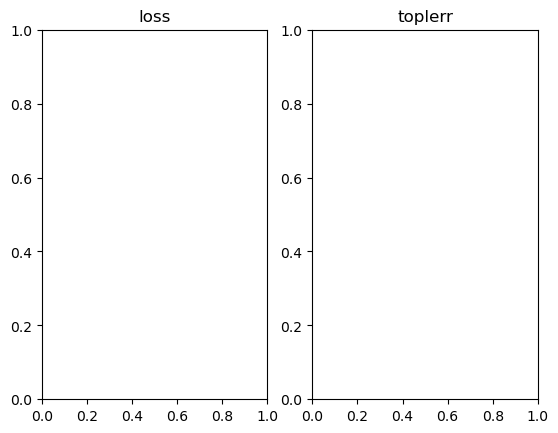

In [20]:
y_loss = {} #Loss history
y_loss['train'] = []
y_loss['val'] = []
y_err = {}
y_err['train'] = []
y_err['val'] = []

x_epoch = []

fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="toplerr")

In [21]:
def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['val'], 'ro-', label='val')
    ax1.plot(x_epoch, y_err['train'], 'bo-', label='train')
    ax1.plot(x_epoch, y_err['val'], 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    fig.savefig(os.path.join('train.jpg'))

In [22]:
logging.basicConfig(filename='train.log', filemode='w', format='%(asctime)s %(process)d %(name)s - %(levelname)s - %(message)s')
logging.warning('This will get logged to a file')

In [24]:
def log(path, file):
    #Check if the file exist
    log_file = os.path.join(path, file)
    if not os.path.isfile(log_file):
        open(log_file, "w+").close()
    
    console_logging_format = "%(levelname)s %(message)s"
    file_logging_format = "%(levelname)s: %(asctime)s: %(message)s"
    
    #configure logger
    logging.basicConfig(level=logging.INFO, format=console_logging_format)
    logger = logging.getLogger()
    
    #create a file handler for output file
    handler = logging.FileHandler(log_file)
    
    #set the logging level for log file
    handler.setLevel(logging.INFO)
    
    #create a logging format
    formatter = logging.Formatter(file_logging_format)
    handler.setFormatter(formatter)
    
    #add the handlers to the logger
    logger.addHandler(handler)
    
    return logger

In [23]:
#Train the model
best_loss = -1
early_stop = 5
best_epoch = -1

#set a logger file
logger = log(path="logs/", file="train.log")

for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    losses = 0
    correct = 0
    print('-'*10)
    for i, sample in enumerate(train_loader):
        images = sample['image']
        
        labels = sample['mudraClass']
        #print(images.type)
        images = images.to(device)
        labels = labels.to(device)
        #print(labels.device)
        optimizer.zero_grad()
        outputs = model(images)
        #print(outputs)
        #print(labels)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(1)
        #Backpropagation
        loss.backward()
        optimizer.step()
        correct += (preds == labels).sum()
        losses+=torch.mean(loss).item()
        images = sample['image'].to('cpu')
        labels = sample['mudraClass'].to('cpu')
        del images, labels, outputs, loss
        torch.cuda.empty_cache()
    
    logger.info("Epoch [{}/{}], Step [{}/{}]".format(epoch+1, num_epochs, i+1, len(train_loader)))
    logger.info("Train loss at epoch {} || {}".format(epoch+1, losses/len(train_loader)))
    
    print('Epoch [{}/{}], Step [{}/{}]'.format(epoch+1, num_epochs, i+1, len(train_loader)))
    print(f"Train Loss at epoch {epoch+1} || {losses/len(train_loader)}")
    y_loss['train'].append(losses/len(train_loader))
    
    y_err['train'].append((1.0 - correct/len(train_loader)).cpu())
    #print(y_err['train'][1].device)
    
    #Validation
    tot_loss = 0.0
    with torch.no_grad():
        correct=0
        samples=0
        for i, sample in enumerate(valid_loader):
            #print(sample['image'].type)
            images = sample['image'].to(device)
            labels = sample['mudraClass'].to(device)
            #print(images.type)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum()
            samples += preds.size(0)
            val_loss = criterion(outputs, labels)

            tot_loss += torch.mean(val_loss).item()
            del images, labels, outputs, val_loss
            torch.cuda.empty_cache()
        acc = float(correct) / float(samples) * 100
            
        if acc > best_acc:
            best_acc = acc
            best_epoch = epoch
            torch.save(model.state_dict(), "best_model.pth")
        elif epoch - best_epoch > early_stop:
            print("Early stopped training at epoch %d" % epoch)
            break
        
        logger.info("Validation accuracy {} percentage || correct {} out of {} samples".format(acc:.2f, correct, samples))
        logger.info("Validation loss for epoch {} || {}".format(epoch+1, tot_loss/len(valid_loader)))
        
        print(f"accuracy {acc:.2f} percentage || Correct {correct} out of {samples} samples")
        print(f"Validation loss for epoch {epoch+1} || {tot_loss/len(valid_loader)}") 
        y_loss['val'].append(tot_loss/len(valid_loader))
        y_err['val'].append((1.0 - correct/len(valid_loader)).cpu())
        draw_curve(epoch)
    model.load_state_dict(torch.load("best_model.pth"))

----------


TypeError: 'int' object is not callable